<div style="text-align: right">Submitted in partial fulfilment for BSc Computer Science | University of London | 02/09/2022</div>
<div style="text-align: right">Jonathan Batty | UoL Student Number: 190164315/1</div>

### BSc(Hons) Computer Science
## CM3070 Final Project

<div style="text-align: left"><img src="images/crest.jpg" width = 115![fig1.png]/></div>

### A 3-dimensional (3D), regression-based, deep learning approach to automate quantification of coronary artery calcification using thoracic computed tomography (CT) images

Jonathan Batty, BSc Computer Science Candidate

### Import all required libraries and set required environment variables

In [1]:
# Import all general libraries to be used here
import os
import random
import datetime
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Import DICOM-related libraries here
import pydicom
from scipy import ndimage

# Import plotting libraries here
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report

# Import ML-specific libraries to be used here
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Activation, Input, concatenate, add, BatchNormalization 
from keras.layers import Dense, LeakyReLU, Reshape, Lambda, Dropout
from keras.layers import Conv3D, UpSampling3D, Conv3DTranspose, MaxPool3D, GlobalAveragePooling3D 
from keras.initializers import RandomNormal
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

# Set random seed for reproducibility
random.seed(0)

In [2]:
# Set details of file directories to be used in this project
data_path = 'data/'
ct_data_path = data_path + 'ct_data/'

### Import calcium score .csv data for CT all scans (the 'Ground Truth')

In [3]:
df = pd.read_csv(data_path + 'calciumscores.csv')
df.head()

,ID,LM,LAD,LCX,RCA,TOTAL
0,0,0.0000,0.0000,0.0000,35.38740,35.38740
1,1,0.0000,1190.1600,35.8850,376.61000,1602.65500
2,2,0.0000,569.4960,209.2764,0.00000,778.77240
3,3,244.9428,1471.7440,73.2750,5.84239,1795.80419
4,4,404.9120,75.7594,101.7102,4.21067,586.59227


### Import CT scan DICOM data

In [5]:
# First, get a list of all the directories containing CT datafiles (these correspond to 'ID' in table above
# Create a dictionary in the form study_id: [path_to_file_1, path_to_file_2, ...] etc

study_list = os.listdir(ct_data_path)

studies = {study: [] for study in study_list}
    
for dirName, subdirList, fileList in os.walk(ct_data_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file is a DICOM
            study_id = dirName.split(os.path.sep)[0].split("/")[2]
            study_path = dirName + "/" + filename
            studies[str(study_id)].append(study_path)


### Data preprocessing steps

In [6]:
# Helper function to resize image to target size
def resize_scan(scan_data, depth, width, height):
    """ Resize CT data across z-axis """
    
    # Set the desired size
    desired_depth = depth
    desired_width = width
    desired_height = height
        
    # Get current size
    current_depth = scan_data.shape[-1]
    current_width = scan_data.shape[0]
    current_height = scan_data.shape[1]
        
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
        
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
        
    # Resize across z-axis
    scan_data = ndimage.zoom(scan_data, (width_factor, height_factor, depth_factor), order = 1)
    return scan_data


## Load scan data into memory

In [7]:
# Iterate over each study, convert each dicom file to appropriate numpy data format 
# Warning: this step takes ~20 minutes and requires ~50 GB of RAM

image_data = []

# Loop over all studies
for study in tq(study_list):
    
    # Get first file as reference file (set pixel spacing, rows, cols, slices, etc)
    reference = pydicom.read_file(studies[str(study)][0])
    const_pixel_dims = (int(reference.Rows), int(reference.Columns), len(studies[str(study)]))
    const_pixel_spacing = (float(reference.PixelSpacing[0]), float(reference.PixelSpacing[1]), float(reference.SliceThickness))
    
    # Calculate appropriate axes for the array
    x = np.arange(0.0, (const_pixel_dims[0]+1)*const_pixel_spacing[0], const_pixel_spacing[0])
    y = np.arange(0.0, (const_pixel_dims[1]+1)*const_pixel_spacing[1], const_pixel_spacing[1])
    z = np.arange(0.0, (const_pixel_dims[2]+1)*const_pixel_spacing[2], const_pixel_spacing[2])
    
    dicom_array = np.zeros(const_pixel_dims)
    
    # Loop through dicom slices
    for ct_slice in studies[str(study)]:
        
        # Import dicom file
        dicom = pydicom.read_file(ct_slice)
        
        # Check that dicom file contains pixel data:
        if "PixelData" in dicom:
        
            # Handle possible misspecified file
            if 'Image Storage' not in dicom.SOPClassUID.name:
               continue

            # Convert imported dicom image to Hounsfield unit scale
            dicom_hu = dicom.pixel_array * dicom.RescaleSlope + dicom.RescaleIntercept

            # Store the slice in dicom_array
            dicom_array[:, :, studies[str(study)].index(ct_slice)] = dicom_hu
                       
    # Run all pre-processing steps in this section
    # Resize scan to 128 x 128 x 32 pixels using helper function above
    processed_scan = resize_scan(dicom_array, 32, 128, 128)
        
    # Append the 3D volume to image_data array
    image_data.append(processed_scan)

  0%|          | 0/785 [00:00<?, ?it/s]

### Convert labels (calcium score data) to NumPy arrays

In [8]:
# Convert total calcium score labels to numpy array
ca_total = df["TOTAL"].to_numpy()

# Convert vessel-specific calcium score labels to numpy array
ca_lmca = df["LM"].to_numpy()
ca_lad = df["LAD"].to_numpy()
ca_lcx = df["LCX"].to_numpy()
ca_rca = df["RCA"].to_numpy()

# In order, all calcified scans are first, followed by non-calcified scans
# Shuffle lists of data and labels (maintaining relative positions of data:label)
labelled_data = list(zip(image_data, ca_total, ca_lmca, ca_lad, ca_lcx, ca_rca))         
random.shuffle(labelled_data)              
image_data, ca_total, ca_lmca, ca_lad, ca_lcx, ca_rca = zip(*labelled_data)

In [9]:
# Concatenate image data matrices within arrays
scan_data = np.array([scan for scan in image_data])

# Convert from a float64 array to float32 array to save memory
scan_data = scan_data.astype('float32')

# Confirm the shape of the array is correct (number of scans x height of each scan x width of each scan x slices of each scan)
scan_data.shape

(785, 128, 128, 32)

### Split data into training (90%), tuning (10%) and test (10%) sets

In [11]:
# n = 785 images overall; now randomly shuffled
# Split into 90% - 10% - 10% train-validation-test split

x_train = scan_data[:629]
y_train = np.array(ca_total[:629])

x_tuning = scan_data[629:707]
y_tuning = np.array(ca_total[629:707])

x_test = scan_data[707:]
y_test = np.array(ca_total[707:])

print("Number of samples in the training, tuning and testing sets are {}, {} and {}.".format(x_train.shape[0], x_tuning.shape[0], x_test.shape[0]))

Number of samples in the training, tuning and testing sets are 629, 78 and 78.


### Define data augmentation, transformations and other preprocessing steps

In [12]:
# Rotate the scan volume by a preset number of degrees
@tf.function
def rotate(scan):
    """Rotate the scan volume randomly, by a few degrees"""

    def scipy_rotate(scan):
        # define some rotation angles
        angles = [-10, -5, -2, 2, 5, 10]
        
        # pick angles at random
        angle = random.choice(angles)
        
        # rotate volume
        scan = ndimage.rotate(scan, angle, reshape=False)
        scan[scan < 0] = 0
        scan[scan > 1] = 1
        return scan

    augmented_scan = tf.numpy_function(scipy_rotate, [scan], tf.float64)
    return scan

In [13]:
# Pre-processing
def trainset_preprocessing(scan, label):
    """Rotate data and add an extra channel"""
    scan = rotate(scan)
    scan = tf.expand_dims(scan, axis = 3)
    return scan, label

def tuningset_preprocessing(scan, label):
    """Add an extra channel to test set"""
    scan = tf.expand_dims(scan, axis = 3)
    return scan, label

def testset_preprocessing(scan, label):
    """Add an extra channel to test set"""
    scan = tf.expand_dims(scan, axis = 3)
    return scan, label

In [14]:
# Define loaders for data and labels
trainset_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tuningset_loader = tf.data.Dataset.from_tensor_slices((x_tuning, y_tuning))
testset_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Set batch size
batch_size = 32

training_dataset = (
    trainset_loader.shuffle(len(x_train))
                   .map(trainset_preprocessing)
                   .batch(batch_size)
                   .prefetch(32)
)

tuning_dataset = (
    tuningset_loader.shuffle(len(x_tuning))
                    .map(tuningset_preprocessing)
                    .batch(batch_size)
                    .prefetch(32)
)

testing_dataset = (
    testset_loader.shuffle(len(x_test))
                  .map(testset_preprocessing)
                  .batch(batch_size)
                  .prefetch(32)
)

### Plot examples of imported data

The calcium score for this scan is: 458.0333
The dimensions of the CT scan are (128, 128, 32, 1):


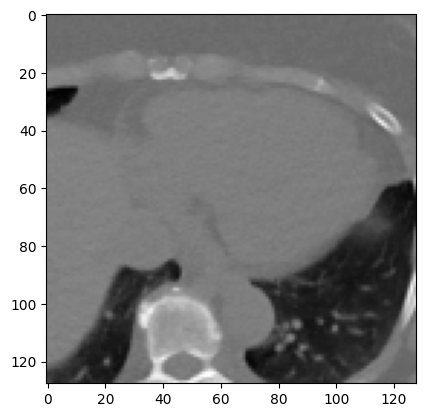

In [15]:
example = training_dataset.take(1)
scans, labels = list(example)[0]
scans = scans.numpy()
scan = scans[0]

print("The calcium score for this scan is: {}".format(labels[0]))
print("The dimensions of the CT scan are {}:".format(scan.shape))
plt.imshow(np.squeeze(scan[:, :, 18]), cmap='gray')

In [17]:
# Helper function that plots a series of CT scan slices
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.flip(data, 0)
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

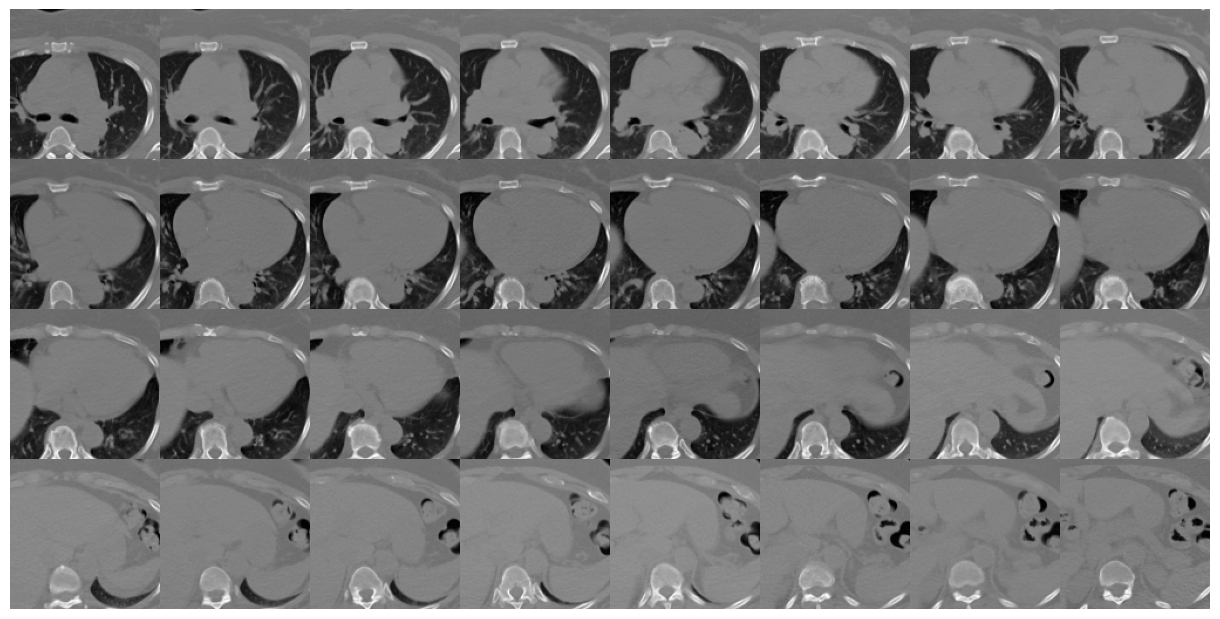

In [18]:
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 8, 128, 128, scan[:, :, :32])

### Create version of datasets with only calcified pixels (i.e. HU > 130)
In earlier iterations of model development, the models failed to converge when all pixel data was used. As calcification is characterised by the presence of dense pixels (i.e. > 130 HU), the input matrices can be 'masked' so that all values < 130 are ignored. In addition, scaling all pixels >130 to be equal to 1 appears to help improve model training and fit.

In [19]:
# Mask any values >= 130 HU as 1 and any values < 130 as 0
for dataset in [x_train, x_tuning, x_test]:
    dataset[dataset < 130] = 0
    dataset[dataset >= 130] = 1

In [20]:
trainset_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tuningset_loader = tf.data.Dataset.from_tensor_slices((x_tuning, y_tuning))
testset_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

training_dataset = (
    trainset_loader.shuffle(len(x_train))
                   .batch(batch_size)
                   .prefetch(32)
)

tuning_dataset = (
    tuningset_loader.shuffle(len(x_tuning))
                    .batch(batch_size)
                    .prefetch(32)
)

testing_dataset = (
    testset_loader.shuffle(len(x_test))
                  .batch(batch_size)
                  .prefetch(32)
)

The calcium score for this scan is: 34.7328
The dimensions of the CT scan are (128, 128, 32):


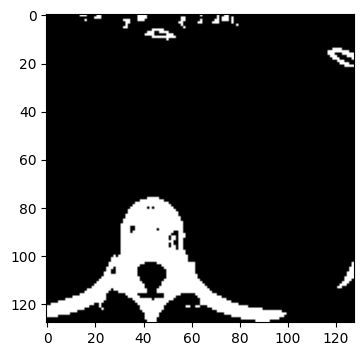

In [21]:
# Plot the same (masked) volume as above
example = training_dataset.take(1)
scans, labels = list(example)[0]
scans = scans.numpy()
scan = scans[0]

print("The calcium score for this scan is: {}".format(labels[0]))
print("The dimensions of the CT scan are {}:".format(scan.shape))
plt.imshow(np.squeeze(scan[:, :, 18]), cmap='gray')

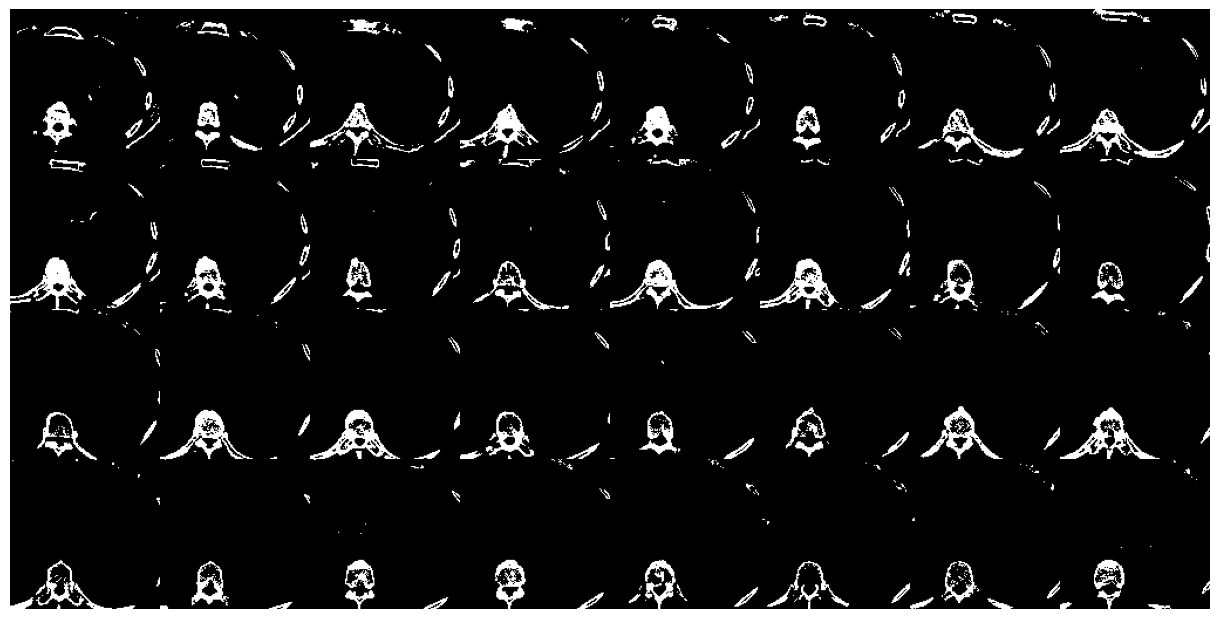

In [23]:
plot_slices(4, 8, 128, 128, scan[:, :, :32])

### Define baseline model (model 1): a CNN-based regression model

In [24]:
# Model based on that used in this paper: https://arxiv.org/abs/2007.13224
def get_model(width = 128, height = 128, depth = 32):
    """Build a 3D CNN model that predicts a scalar value (linear output)"""

    inputs = Input((width, height, depth, 1))

    x = Conv3D(filters = 64, kernel_size = 3, activation = "relu", )(inputs)
    x = MaxPool3D(pool_size = 3)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters = 128, kernel_size = 3, activation = "relu")(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters = 128, kernel_size = 3, activation = "relu")(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units = 512, activation = "relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units = 1, activation = "relu")(x)

    # Define the model.
    model_1 = keras.Model(inputs, outputs, name = "calcium_quantification_model_1")
    return model_1

In [25]:
# Build the model:
model_1 = get_model(width = 128, height = 128, depth = 32)
model_1.summary()

Model: "calcium_quantification_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 32, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 30, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 42, 42, 10, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 42, 42, 10, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 8, 128)    221312    
                                    

### Running model 1

In [26]:
# Compile the model
initial_learning_rate = 0.0001

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                                     decay_steps = 100000, 
                                                                     decay_rate = 0.96, 
                                                                     staircase = True)

model_1.compile(loss= tf.keras.losses.MeanAbsoluteError(),
                optimizer= keras.optimizers.Adam(learning_rate = learning_rate_schedule),
                metrics=[tf.keras.losses.MeanAbsoluteError()],)

# Define callbacks; save checkpoint model file every 5 epochs
checkpoint_callback = keras.callbacks.ModelCheckpoint('checkpoints/calcium_quantification_model_1_{epoch:05d}.h5',
                                                      save_freq = 'epoch',
                                                      save_weights_only = False,
                                                      save_best_only = True)

# Train the model; perform validation at the end of each epoch
epochs = 100

history = model_1.fit(training_dataset,
                      validation_data = tuning_dataset,
                      epochs = epochs,
                      shuffle = True,
                      verbose = 2,
                      callbacks = [checkpoint_callback],)

model_1.save('checkpoints/model_1.h5') 

Epoch 1/100
20/20 - 480s - loss: 1024.2825 - val_loss: 1148.7984 - 480s/epoch - s/step
Epoch 2/100
20/20 - 476s - loss: 566.5706 - val_loss: 962.6542 - 476s/epoch - s/step
Epoch 3/100
20/20 - 474s - loss: 646.4701 - val_loss: 830.2916 - 474s/epoch - s/step
Epoch 4/100
20/20 - 486s - loss: 494.3355 - val_loss: 781.2823 - 486s/epoch - s/step
Epoch 5/100
20/20 - 489s - loss: 460.9108 - val_loss: 763.2562 - 489s/epoch - s/step
Epoch 6/100
20/20 - 490s - loss: 410.2878 - val_loss: 742.5896 - 490s/epoch - s/step
Epoch 7/100
20/20 - 488s - loss: 355.5802 - val_loss: 737.8620 - 488s/epoch - s/step
Epoch 8/100
20/20 - 487s - loss: 350.1148 - val_loss: 758.1613 - 487s/epoch - s/step
Epoch 9/100
20/20 - 488s - loss: 309.1024 - val_loss: 732.1610 - 488s/epoch - s/step
Epoch 10/100
20/20 - 487s - loss: 370.3667 - val_loss: 701.2682 - 487s/epoch - s/step
Epoch 11/100
20/20 - 478s - loss: 328.4022 - val_loss: 788.2680 - 478s/epoch - s/step
Epoch 12/100
20/20 - 466s - loss: 310.1445 - val_loss: 681.26

### Evaluating model 1:
#### Performance during model training

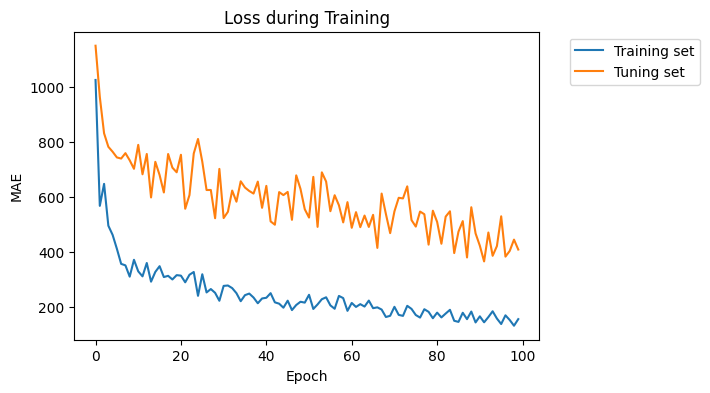

In [27]:
# Reimport saved history object
history = pd.read_csv(data_path + 'model_1_training.csv')

def plot_training_loss(history_df):
    history_df[['training_MAE', 'tuning_MAE']].plot.line()
    plt.legend(['Training set', 'Tuning set'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.rcParams["figure.figsize"] = (6, 4)
    
plot_training_loss(history)

#### Performance in the held-out validation set
#### Relationship between actual vs. predicted labels

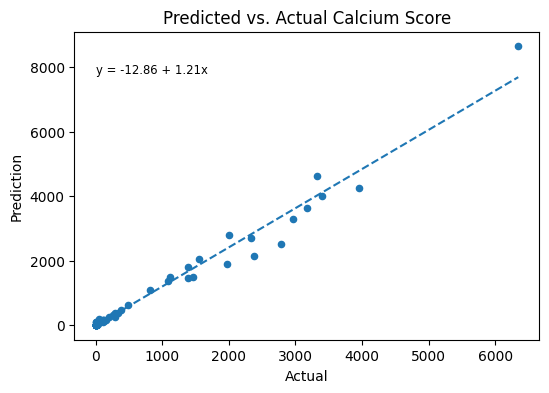

In [28]:
# Reimport saved predictions 
pred = pd.read_csv(data_path + 'model_1_predictions.csv')
pred.sort_values(['ID'])

def plot_predicted_vs_actual(pred_df):
    pred_df.plot.scatter(x = 'Actual', y = 'Prediction')
    a, b = np.polyfit(pred_df['Actual'], pred_df['Prediction'], 1)
    plt.plot(pred['Actual'], a*pred['Actual'] + b, linestyle='--')
    plt.title('Predicted vs. Actual Calcium Score')
    max_y = pred_df['Prediction'].max() * 0.9
    plt.text(0, max_y, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size = 'small')
    plt.rcParams["figure.figsize"] = (6, 4)
    
plot_predicted_vs_actual(pred)

### Evaluation of classification metrics (model 1, validation set)

In [29]:
def binary_calcium_score(x):
    if x < 100:
        return 0
    if x >= 100:
        return 1
    
def categorise_calcium_score(x):
    if x == 0:
        return 0
    if x > 0 and x < 100:
        return 1
    if x >= 100 and x < 200:
        return 2
    if x >= 200 and x < 300:
        return 3
    if x >= 300 and x < 400:
        return 4
    if x > 400:
        return 5

def apply_categories(df):    
    df['act_binary_cat'] = df['Actual'].apply(binary_calcium_score)
    df['pred_binary_cat'] = df['Prediction'].apply(binary_calcium_score)
    df['act_cat'] = df['Actual'].apply(categorise_calcium_score)
    df['pred_cat'] = df['Prediction'].apply(categorise_calcium_score)
    return df

pred = apply_categories(pred)

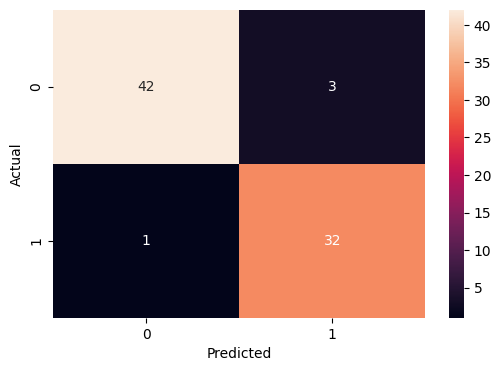

In [30]:
# Show confusion matrix based on binary calcium groupings
def binary_confusion_matrix(pred_df):
    confusion_matrix = pd.crosstab(pred_df['act_binary_cat'], pred_df['pred_binary_cat'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot = True)
    plt.rcParams["figure.figsize"] = (6, 4)
    plt.show()
    return confusion_matrix
    
confusion_matrix = binary_confusion_matrix(pred)

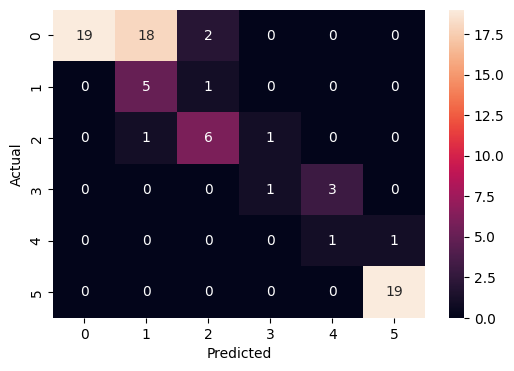

In [31]:
# Show confusion matrix based on groups dividing calcium score at intervals of 100
def categorical_confusion_matrix(pred_df):
    category_matrix = pd.crosstab(pred_df['act_cat'], pred_df['pred_cat'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(category_matrix, annot = True)
    plt.rcParams["figure.figsize"] = (6, 4)
    plt.show()
    return category_matrix
    
category_matrix = categorical_confusion_matrix(pred)

In [32]:
# Binary classification evaluation:
def binary_classification_stats(confusion_matrix):
    tp = confusion_matrix[1][1]
    tn = confusion_matrix[0][0]
    fp = confusion_matrix[1][0]
    fn = confusion_matrix[0][1]

    binary_sensitivity = tp / (tp + fn)
    binary_specificity = tn / (tn + fp)
    binary_ppv = tp / (tp + fp)
    binary_npv = tn / (tn + fn)
    binary_F1 = (2 * tp) / ((2 * tp) + fp + fn)
    binary_fpr = fp / (fp + tp)
    binary_fnr = fn / (fn + tn)
    binary_accuracy = (tp + tn) / (tp + tn + fp + fn)

    print("Binary classification, CAC < 100 vs. CAC >= 100:")
    print("Sensitivity (recall):       {:.2f}".format(binary_sensitivity))
    print("Specificity:                {:.2f}".format(binary_specificity))
    print("PPV                         {:.2f}".format(binary_ppv))
    print("NPV (Precision):            {:.2f}".format(binary_npv))
    print("F1 score:                   {:.2f}".format(binary_F1))
    print("False positive rate:        {:.2f}".format(binary_fpr))
    print("False negative rate:        {:.2f}".format(binary_fnr))
    print("Class accuracy:             {:.2f}".format(binary_accuracy))
    print("\n")
          
binary_classification_stats(confusion_matrix)

Binary classification, CAC < 100 vs. CAC >= 100:
Sensitivity (recall):       0.97
Specificity:                0.93
PPV                         0.91
NPV (Precision):            0.98
F1 score:                   0.94
False positive rate:        0.09
False negative rate:        0.02
Class accuracy:             0.95




In [33]:
# Multiclass classification evaluation:
def cat_classification_stats(pred_df):
    y_true = pred_df['act_cat'].tolist()
    y_pred = pred_df['pred_cat'].tolist()

    print("Categorical classification:")
    print("Groups: 0 - CAC = 0 , 1 - CAC < 100 , 2 - CAC 100 - 199, 3 - CAC 200 - 299, 4 - CAC 300 - 399, 5 - CAC > 400")

    report = classification_report(y_true = y_true, y_pred = y_pred, zero_division = 0)
    print(report)
    
cat_classification_stats(pred)

Categorical classification:
Groups: 0 - CAC = 0 , 1 - CAC < 100 , 2 - CAC 100 - 199, 3 - CAC 200 - 299, 4 - CAC 300 - 399, 5 - CAC > 400
              precision    recall  f1-score   support

           0       1.00      0.49      0.66        39
           1       0.21      0.83      0.33         6
           2       0.67      0.75      0.71         8
           3       0.50      0.25      0.33         4
           4       0.25      0.50      0.33         2
           5       0.95      1.00      0.97        19

    accuracy                           0.65        78
   macro avg       0.60      0.64      0.56        78
weighted avg       0.85      0.65      0.69        78



### The optimised model: a 3D U-Net-based regression model


In [34]:
# Define the 3D U-Net model
# Adapted from: https://github.com/chestnut111/3D-unet-keras-Brats2019/blob/master/train/network.py
from keras.layers import Dense

def myConv(x_in, nf, strides=1, kernel_size = 3):
    x_out = Conv3D(nf, kernel_size=3, padding='same',kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = BatchNormalization()(x_out)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out


def Unet3dBlock(l, n_feat):
    l_in = l
    for i in range(2):
        l = myConv(l, n_feat)
    return add([l_in, l])


def UnetUpsample(l, num_filters):
    l = UpSampling3D()(l)
    l = myConv(l, num_filters)
    return l

def unet3d(vol_size):
    inputs = Input(shape=vol_size)
    depth = 5
    filters = []
    down_list = []
    deep_supervision = None
    layer = myConv(inputs, 16)
    
    for d in range(depth):
        num_filters = 16 * (2**d)
        filters.append(num_filters)
        layer = Unet3dBlock(layer, n_feat = num_filters)
        down_list.append(layer)
        if d != depth - 1:
            layer = myConv(layer, num_filters*2, strides=2)
        
    for d in range(depth-2, -1, -1):
        layer = UnetUpsample(layer, filters[d])
        layer = concatenate([layer, down_list[d]])
        layer = myConv(layer, filters[d])
        layer = myConv(layer, filters[d], kernel_size = 1)
        
        if 0< d < 3:
            pred = myConv(layer, 4)
            if deep_supervision is None:
                deep_supervision = pred
            else:
                deep_supervision = add([pred, deep_supervision])
            deep_supervision = UpSampling3D()(deep_supervision)
    
    layer = myConv(layer, 4, kernel_size = 1)
    
    layer = add([layer, deep_supervision])
    layer = myConv(layer, 4, kernel_size = 1)
    x = Dense(units = 1, activation = "relu")(layer)
        
    model = Model(inputs=[inputs], outputs=[x])
    return model

In [35]:
# Build the model - use same format as above
model_2 = unet3d((128,128,32,1))
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                2, 1)]                                                            
                                                                                                  
 conv3d_3 (Conv3D)              (None, 128, 128, 32  448         ['input_2[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 128, 32  64         ['conv3d_3[0][0]']               
 rmalization)                   , 16)                                                         

In [36]:
# Compile the model
model_2.compile(loss= tf.keras.losses.MeanAbsoluteError(),
                optimizer= keras.optimizers.Adam(learning_rate = learning_rate_schedule),
                metrics=[tf.keras.losses.MeanAbsoluteError()],)

# Define callbacks; save checkpoint model file every 5 epochs
checkpoint_callback = keras.callbacks.ModelCheckpoint('checkpoints/calcium_quantification_model_2_{epoch:05d}.h5',
                                                      save_freq = 'epoch',
                                                      save_weights_only = False,
                                                      save_best_only = True)

# Train the model; perform validation at the end of each epoch
history2 = model_2.fit(training_dataset,
                       validation_data = tuning_dataset,
                       epochs = epochs,
                       shuffle = True,
                       verbose = 2,
                       callbacks = [checkpoint_callback],)

model_2.save('checkpoints/model_2.h5') 

Epoch 1/100
20/20 - 2775s - loss: 2557.5370 - val_loss: 2424.0752 - 2775s/epoch - 139s/step
Epoch 2/100
20/20 - 2859s - loss: 1460.4267 - val_loss: 2312.8113 - 2859s/epoch - 143s/step
Epoch 3/100
20/20 - 2690s - loss: 2123.4781 - val_loss: 1886.1045 - 2690s/epoch - 135s/step
Epoch 4/100
20/20 - 2785s - loss: 1642.3362 - val_loss: 2085.8445 - 2785s/epoch - 139s/step
Epoch 5/100
20/20 - 2919s - loss: 1621.7270 - val_loss: 1878.8601 - 2919s/epoch - 146s/step
Epoch 6/100
20/20 - 2656s - loss: 1819.5624 - val_loss: 2022.7744 - 2656s/epoch - 133s/step
Epoch 7/100
20/20 - 2986s - loss: 1462.4010 - val_loss: 1585.8750 - 2986s/epoch - 149s/step
Epoch 8/100
20/20 - 2965s - loss: 1016.2789 - val_loss: 1658.0911 - 2965s/epoch - 148s/step
Epoch 9/100
20/20 - 2745s - loss: 1238.1710 - val_loss: 1217.3925 - 2745s/epoch - 137s/step
Epoch 10/100
20/20 - 2863s - loss: 1107.4883 - val_loss: 1320.5217 - 2863s/epoch - 143s/step
Epoch 11/100
20/20 - 2753s - loss: 1015.6663 - val_loss: 1210.7442 - 2753s/epoc

### Evaluating model 2:
#### Performance during model training

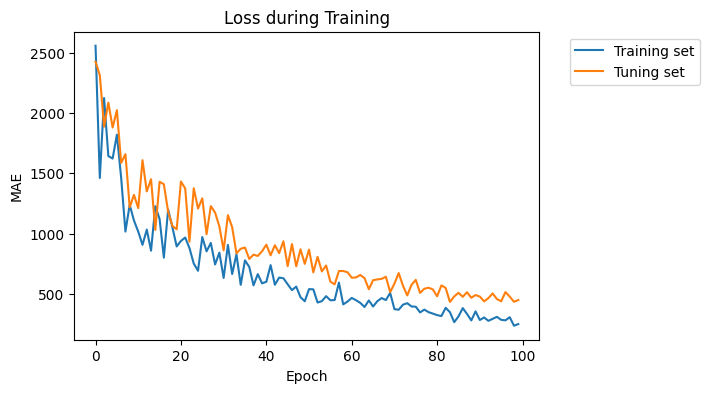

In [37]:
# Reimport saved history object
history = pd.read_csv(data_path + 'model_2_training.csv')
plot_training_loss(history)

#### Performance in the held-out validation set
#### Relationship between actual vs. predicted labels

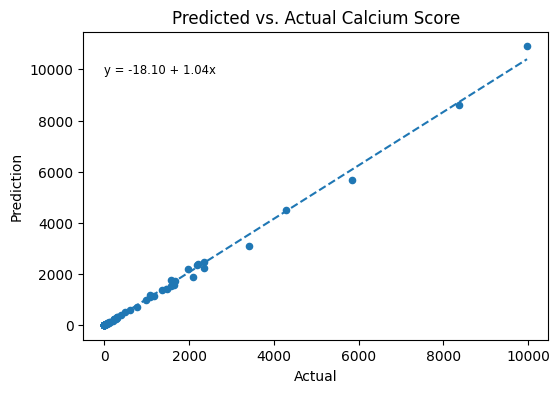

In [38]:
# Reimport saved predictions 
pred = pd.read_csv(data_path + 'model_2_predictions.csv')

plot_predicted_vs_actual(pred)

### Evaluation of classification metrics (model 1, validation set)

In [39]:
pred = apply_categories(pred)

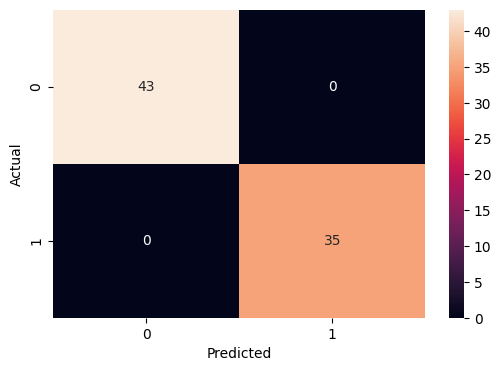

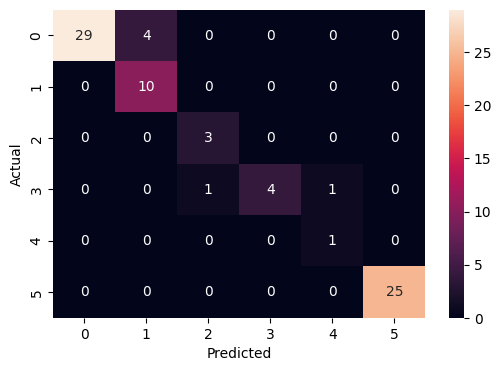

In [40]:
# Show confusion matrix based on binary and categorical calcium groupings
confusion_matrix = binary_confusion_matrix(pred)
category_matrix = categorical_confusion_matrix(pred)

In [41]:
binary_classification_stats(confusion_matrix)
cat_classification_stats(pred)

Binary classification, CAC < 100 vs. CAC >= 100:
Sensitivity (recall):       1.00
Specificity:                1.00
PPV                         1.00
NPV (Precision):            1.00
F1 score:                   1.00
False positive rate:        0.00
False negative rate:        0.00
Class accuracy:             1.00


Categorical classification:
Groups: 0 - CAC = 0 , 1 - CAC < 100 , 2 - CAC 100 - 199, 3 - CAC 200 - 299, 4 - CAC 300 - 399, 5 - CAC > 400
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       0.71      1.00      0.83        10
           2       0.75      1.00      0.86         3
           3       1.00      0.67      0.80         6
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00        25

    accuracy                           0.92        78
   macro avg       0.83      0.92      0.85        78
weighted avg       0.95      0.92      0.93        78



### Final model evaluation using the held-out test set
#### Perform inference (prediction) based on model 2

In [42]:
model = keras.models.load_model('/checkpoints/model2.h5')

label_list = []
pred_list = []

for test_scan in testing_dataset:
    scans, labels = list(test_scan)[0]
    label_list.append[labels[0]
    prediction = model.predict(test_scan)[0]
    pred_list.append(prediction)

predictions = list(zip(label_list, pred_list))
preds = pd.DataFrame(predictions, columns = ["Actual", "Predicted"])

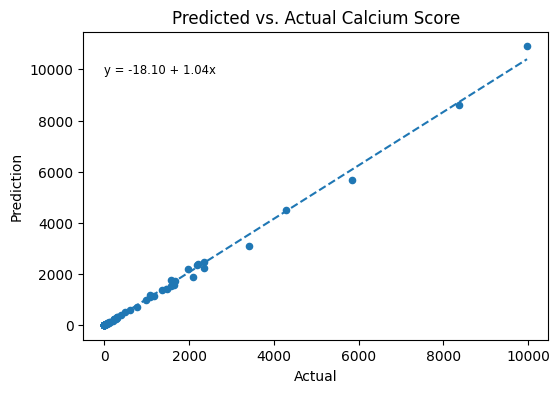

In [43]:
# Reimport saved predictions 
pred = pd.read_csv(data_path + 'model_2_predictions.csv')

plot_predicted_vs_actual(pred)

In [44]:
pred = apply_categories(pred)

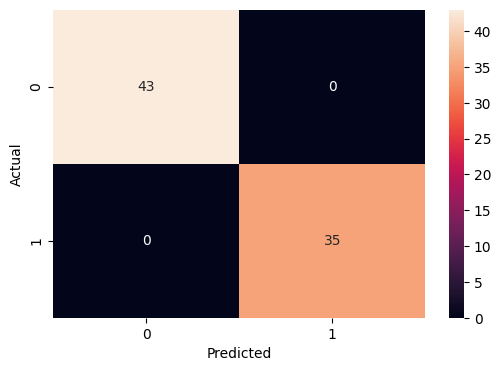

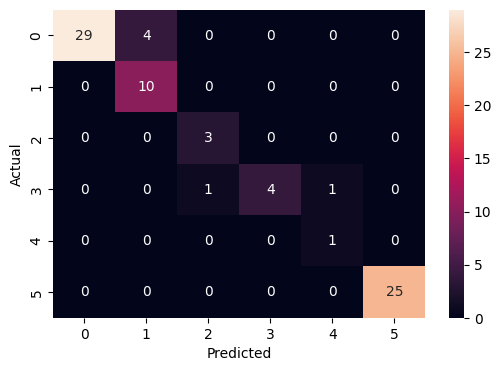

In [45]:
# Show confusion matrix based on binary and categorical calcium groupings
confusion_matrix = binary_confusion_matrix(pred)
category_matrix = categorical_confusion_matrix(pred)

In [46]:
# Show confusion matrix based on binary and categorical calcium groupings
binary_classification_stats(confusion_matrix)
cat_classification_stats(pred)

Binary classification, CAC < 100 vs. CAC >= 100:
Sensitivity (recall):       1.00
Specificity:                1.00
PPV                         1.00
NPV (Precision):            1.00
F1 score:                   1.00
False positive rate:        0.00
False negative rate:        0.00
Class accuracy:             1.00


Categorical classification:
Groups: 0 - CAC = 0 , 1 - CAC < 100 , 2 - CAC 100 - 199, 3 - CAC 200 - 299, 4 - CAC 300 - 399, 5 - CAC > 400
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       0.71      1.00      0.83        10
           2       0.75      1.00      0.86         3
           3       1.00      0.67      0.80         6
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00        25

    accuracy                           0.92        78
   macro avg       0.83      0.92      0.85        78
weighted avg       0.95      0.92      0.93        78



### Example of Single Model Inference

In [47]:
model = keras.models.load_model('checkpoints/model_1.h5')

In [48]:
calcium_score = model.predict(np.expand_dims(x_test[0], axis=0))[0][0]
print(calcium_score)

1/1 [==============================] - 0s 74ms/step
306.38623
